In [20]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

In [2]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv('../data/external/stats/pokemon-gen-1-8.csv')
# pokemon["Variety"] = float("NaN")
pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

# Create one-hot columns for each type
types = set(pokemon["type1"])
for t in types:
    pokemon["is" + str(t).capitalize()] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["type1"].capitalize()] = 1

    if not pd.isna(p["type2"]):
        pokemon.loc[i, "is" + p["type2"].capitalize()] = 1

# Save output
pokemon.to_csv('../data/processed/pokemon.csv', index=False)

pokemon.head()

,pokedex_number,name,type1,type2,isPoison,isFairy,isGround,isSteel,isBug,isGhost,...,isWater,isGrass,isDragon,isRock,isPsychic,isFighting,isFlying,isFire,isNormal,isElectric
0,1,Bulbasaur,grass,poison,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,Ivysaur,grass,poison,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,Venusaur,grass,poison,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Process image data

data_directory_images = "../data/external/images-gen-1-8"
output_directory = "../data/processed/pokemon"

pokemon = pd.read_csv('../data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]
    
    # Add leading zeroes to ID
    while len(pokemon_id) < 3:
        pokemon_id = "0" + pokemon_id

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images + "/" + image
        dst = output_directory + "/" + pokemon_id + ".png"

        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["pokedex_number"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv('../data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

,pokedex_number,name,type1,type2,isPoison,isFairy,isGround,isSteel,isBug,isGhost,...,isGrass,isDragon,isRock,isPsychic,isFighting,isFlying,isFire,isNormal,isElectric,imagePath
0,1,Bulbasaur,grass,poison,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/001.png
1,2,Ivysaur,grass,poison,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/002.png
2,3,Venusaur,grass,poison,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/003.png
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,../data/processed/pokemon/004.png
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,../data/processed/pokemon/005.png


In [4]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon.iloc[i]["imagePath"], color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

X.shape

100%|██████████████████████████████████████████████████████████████████████████| 801/801 [00:04<00:00, 174.96it/s]


(801, 475, 475, 4)

In [5]:
# Create labels
y = pokemon[["isWater"]]
y.shape

(801, 1)

In [28]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


In [29]:
img_input = layers.Input(shape=(475, 475, 4))

model = Sequential()

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(475, 475, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))

model.add(Dense(8, activation="relu"))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=0.001) #Adam, RMSprop or SGD

model.compile(
    loss='binary_crossentropy'
    , optimizer=optimizer
    , metrics=[keras.metrics.AUC()]
#     , metrics=[keras.metrics.Recall()]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 471, 471, 4)       404       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 235, 235, 4)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 235, 235, 4)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 231, 231, 4)       404       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 115, 115, 4)      0         
 g2D)                                                            
                                                                 
 dense_10 (Dense)            (None, 115, 115, 8)      

Epoch 1/10


2022-08-29 14:29:17.970751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.3788 - auc_5: 0.4824

2022-08-29 14:29:22.568524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 5s 625ms/step - loss: 0.3788 - auc_5: 0.4824 - val_loss: 0.9745 - val_auc_5: 0.5645
Epoch 2/10
6/6 [==============================] - 3s 498ms/step - loss: 0.2654 - auc_5: 0.5846 - val_loss: 0.6787 - val_auc_5: 0.4302
Epoch 3/10
6/6 [==============================] - 3s 476ms/step - loss: 0.2620 - auc_5: 0.7231 - val_loss: 0.6756 - val_auc_5: 0.4363
Epoch 4/10
6/6 [==============================] - 3s 477ms/step - loss: 0.2574 - auc_5: 0.7431 - val_loss: 0.6878 - val_auc_5: 0.4479
Epoch 5/10
6/6 [==============================] - 3s 470ms/step - loss: 0.2511 - auc_5: 0.7829 - val_loss: 0.6981 - val_auc_5: 0.4648
Epoch 6/10
6/6 [==============================] - 3s 474ms/step - loss: 0.2461 - auc_5: 0.8164 - val_loss: 0.7052 - val_auc_5: 0.4785
Epoch 7/10
6/6 [==============================] - 3s 474ms/step - loss: 0.2403 - auc_5: 0.8405 - val_loss: 0.7039 - val_auc_5: 0.4991
Epoch 8/10
6/6 [==============================] - 3s 470ms/step - loss: 0

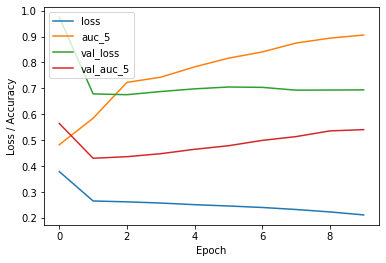

In [30]:
# Now train the model

def calculate_class_weights(y_train):
    ratio_true = sum(y_train["isWater"] == 1) / len(y_train["isWater"])
    ratio_false = sum(y_train["isWater"] != 1) / len(y_train["isWater"])

    return {0: ratio_true, 1: ratio_false}


estimator = model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test),
                      class_weight= calculate_class_weights(y_train),
                      epochs=10, 
                      batch_size=120,
                      verbose=1)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')

for k in estimator.history.keys():
    plt.plot(estimator.history[k], label = k) 
plt.legend(loc='best')
plt.show()


0.56013685


2022-08-29 14:29:51.198775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


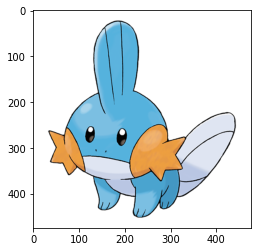

In [31]:
def predict_pokemon(id: str, verbose=0):
    
    while len(id) < 3:
        id = "0" + id
    
    img = tf.keras.utils.load_img(f'../data/processed/pokemon/{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

26/26 [==============================] - 1s 32ms/step


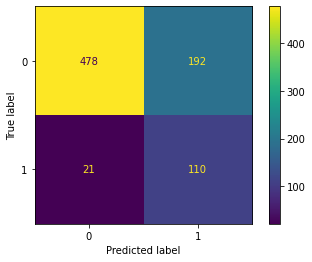

In [32]:
predictions = model.predict(X) > 0.5
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Attribution:

https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
https://www.kaggle.com/datasets/rounakbanik/pokemon